In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# 读取数据
data = pd.read_csv('dataset/NBA_Season_Stats.csv')

# 数据清理：去除无关列并处理缺失值
data_cleaned = data.drop(columns=['Player', 'Tm', 'Year'])
data_cleaned = data_cleaned.dropna()

# 特征工程：创建PTS_per_min特征
data_cleaned['PTS_per_min'] = data_cleaned['PTS'] / data_cleaned['MP']

# 选择用于分类的特征（根据重要性排名）
selected_features = ['AST', 'TRB', 'MP', 'DRB', 'ORB', 'STL', 'BLK', 'FG%', 'eFG%', 'PF', 'TOV', 'PTS', '2P%', 'G', 'PTS_per_min', '3P%', 'Age', 'FT%']

X = data_cleaned[selected_features]
y = data_cleaned['Pos']

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
import time
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.optim.lr_scheduler import LambdaLR
import warnings
import pandas as pd

# 忽略警告
warnings.filterwarnings('ignore')

# 确认设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 修改ResNet18模型以适应输入特征数和类别数
class ResNet18Model(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ResNet18Model, self).__init__()
        self.resnet = resnet18(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.num_features = num_features

    def forward(self, x):
        x = x.view(-1, 1, self.num_features, 1)  # 调整输入形状以适应ResNet18
        return self.resnet(x)

# 初始化模型、损失函数和优化器
model = ResNet18Model(num_features=X_train.shape[1], num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学习率warmup策略
def lr_lambda(epoch):
    if epoch < 10:
        return float(epoch) / 10
    else:
        return 1.0

scheduler = LambdaLR(optimizer, lr_lambda)

# 重新训练时加载模型
start_epoch = 0
model_path = 'model/resnet18_nba_model_39_60.pth'
try:
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_path}")
    start_epoch = int(input("Enter the last completed epoch: ")) - 1
except FileNotFoundError:
    print(f"No saved model found at {model_path}. Starting from scratch.")

# 训练模型
num_epochs = 60
patience = 10  # 提前终止的耐心值
best_accuracy = 0
epochs_no_improve = 0

results = []
model.train()

try:
    for epoch in range(start_epoch, num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # 计算每个epoch的时间
        end_time = time.time()
        epoch_time = end_time - start_time
        
        # 计算测试集上的准确率
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test

        # 保存每个epoch的结果到results列表
        results.append({
            'Epoch': epoch + 1,
            'Loss': epoch_loss,
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy
        })

        # 输出每个epoch的训练和测试集上的准确率
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.6f}%, Test Accuracy: {test_accuracy:.6f}%, Time: {epoch_time:.2f}s')

        # 学习率调度器步进
        scheduler.step()

        # 提前终止策略
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            epochs_no_improve = 0
            # 保存最佳模型
            torch.save(model.state_dict(), f'model/resnet18_nba_model_best.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

except KeyboardInterrupt:
    print("Training interrupted. Saving model...")

finally:
    # 保存模型的当前状态
    interrupted_model_path = f'model/resnet18_nba_model_{epoch+1}_{num_epochs}.pth'
    torch.save(model.state_dict(), interrupted_model_path)
    print(f'Model saved to {interrupted_model_path}')
    # 保存最终结果到CSV文件
    df = pd.DataFrame(results)
    df.to_csv(f'model/resnet18_nba_model_{epoch+1}_{num_epochs}_final_result.csv', index=False)

# 评估模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Final Test Accuracy: {accuracy:.6f}%')

No saved model found at model/resnet18_nba_model_39_60.pth. Starting from scratch.
Epoch [1/60], Loss: 1.8344, Train Accuracy: 16.111483%, Test Accuracy: 16.270506%, Time: 21.75s
Epoch [2/60], Loss: 1.1153, Train Accuracy: 50.987613%, Test Accuracy: 55.574155%, Time: 15.00s
Epoch [3/60], Loss: 0.9634, Train Accuracy: 56.996987%, Test Accuracy: 59.892869%, Time: 14.81s
Epoch [4/60], Loss: 0.9057, Train Accuracy: 59.834282%, Test Accuracy: 60.093740%, Time: 14.97s
Epoch [5/60], Loss: 0.8662, Train Accuracy: 61.868095%, Test Accuracy: 63.073318%, Time: 14.35s
Epoch [6/60], Loss: 0.8446, Train Accuracy: 62.721794%, Test Accuracy: 62.403750%, Time: 14.30s
Epoch [7/60], Loss: 0.8231, Train Accuracy: 63.550385%, Test Accuracy: 63.006361%, Time: 14.44s
Epoch [8/60], Loss: 0.8296, Train Accuracy: 63.516907%, Test Accuracy: 64.178105%, Time: 14.30s
Epoch [9/60], Loss: 0.8179, Train Accuracy: 63.759625%, Test Accuracy: 62.604620%, Time: 14.26s
Epoch [10/60], Loss: 0.8007, Train Accuracy: 64.66354

In [6]:
# 加载训练好的模型
model = ResNet18Model(num_features=X_train.shape[1], num_classes=5).to(device)
model.load_state_dict(torch.load('model/resnet18_nba_model_23_60.pth'))

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.6f}%')

Accuracy: 65.082022%


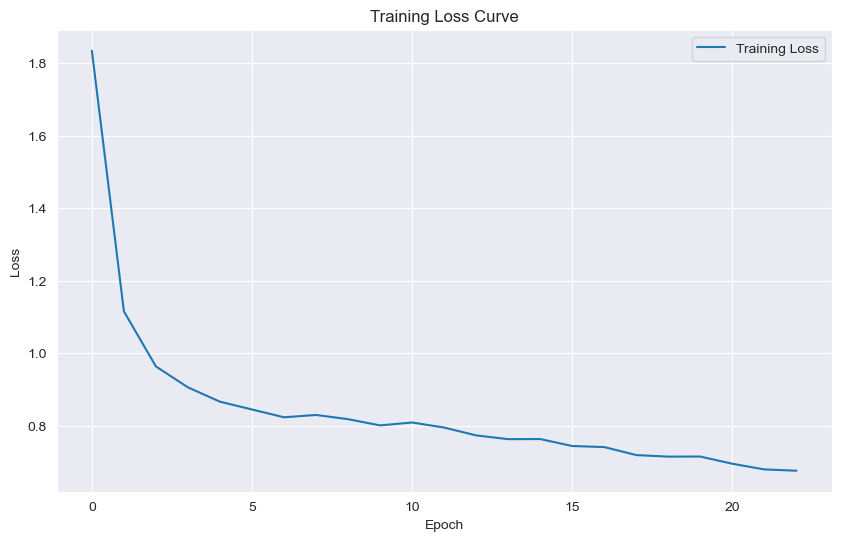

In [7]:
# 可视化训练损失曲线
import matplotlib.pyplot as plt

# 读取model/resnet18_nba_model_27_50_final_result.csv文件
df = pd.read_csv('model/resnet18_nba_model_23_60_final_result.csv')
train_losses = df['Loss']

# 绘制训练损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

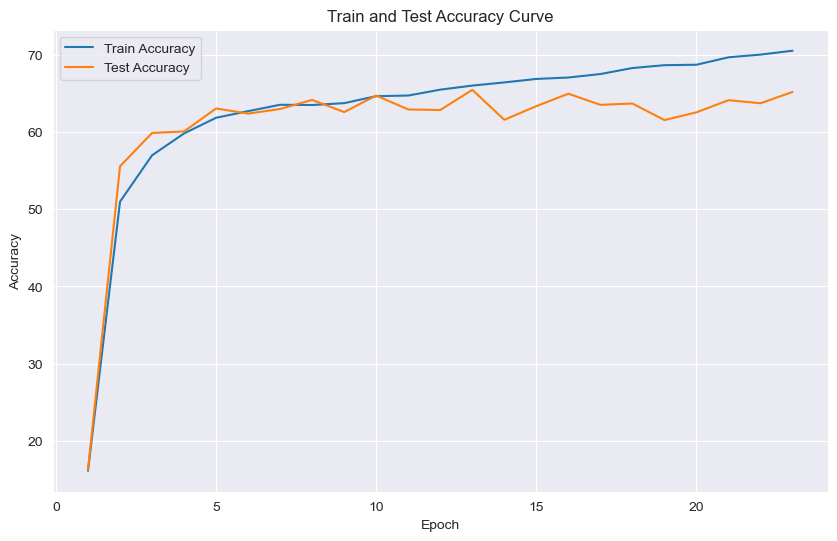

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 读取model/resnet18_nba_model_33_50_final_result.csv文件
df = pd.read_csv('model/resnet18_nba_model_23_60_final_result.csv')
train_accuracy = df['Train Accuracy']
test_accuracy = df['Test Accuracy']
# 读取epoch数
csv_num_epochs = df['Epoch']

# 绘制训练和测试集上的准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(csv_num_epochs, train_accuracy, label='Train Accuracy')
plt.plot(csv_num_epochs, test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Curve')
plt.legend()
plt.show()

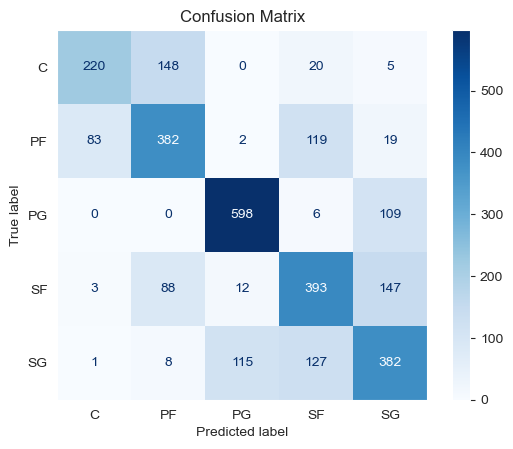

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 计算测试集上的混淆矩阵
all_labels = []
all_predictions = []

# 加载训练好的模型
model = ResNet18Model(num_features=X_train.shape[1], num_classes=5).to(device)
model.load_state_dict(torch.load('model/resnet18_nba_model_best.pth'))
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 绘制混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_predictions)
disp =  ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()